# II. Ensembles

В задачах нужно корректно реализовать функции, чтобы проходили тесты. 

## 1. Bootstrap.

### Алгоритм Bootstrap 
* Равномерно возьмем из выборки $N$ объектов **с возвращением**. То есть мы хотим сгенерировать псевдовыборку, в которой могут повторятся элементы из исходной выборки. 

* Обозначим новую выборку через $X_1$. Повторяя процедуру $B$ раз, сгенерируем $M$ подвыборок $X_1, \dots, X_B$. 

* Посчитаем статистику T от каждой выборки $(T(X_1), \ldots, T(X_n))$

* Найдем итоговую статистику $T(X) = \frac{1}{B}\sum^{B}_{i}T(X_i)$

На вход массив чисел $X$ и число бутстрепных выборок $B$. Необходимо реализовать свой бутстреп и найти матожидание и стандартную ошибку у бутстрепных выборок.


### TASK

In [1]:
import numpy as np
from scipy.stats import sem # ищет SE среднего

def get_stats(X: np.array, B:int)->tuple:
    '''
        .∧＿∧ 
        ( ･ω･｡)つ━☆・*。 
        ⊂  ノ    ・゜+. 
        しーＪ   °。+ *´¨) 
                .· ´¸.·*´¨) 
                (¸.·´ (¸.·'* ☆  <YOUR CODE>
    '''
    sample_mean = [ ]
    sample_se = [ ]
    
    for _ in range(B): 
        sample_x = np.random.choice(X, size=X.size) #выбирая случайным образом элементы из X создаем псевдовыборку
        sample_se.append(sem(sample_x)) #считаем SE от получившейся псевдоыборки
        sample_mean.append(sample_x.mean()) #считаем мат.ож. у получившейся псевдовыборки
        
    mean = np.array(sample_mean).mean() #находим средние значения мат. ож. и стандартной ошибки
    SE = np.array(sample_se).mean()
    print('mean =',mean)
    print('SE =',SE)
    
    return mean, SE

### Open tests

In [2]:
######################################################
X = np.array([37,43,38,36,17,40,40,45,41,84])
B = 100000

mean, se = get_stats(X, B)

assert np.abs(mean - 42.1) < 0.05
assert np.abs(se - 4.56) < 0.03
######################################################

mean = 42.119972000000004
SE = 4.567318598197421


# 2. Bagging

Необходимо реализовать свой небольшой беггинг на деревьях заданной грубины

* бустингом сделать несколько выборок $X_1, \ldots, X_B$
* обучить на этих выборках алгоритмы: $a_1(\cdot), \ldots, a_B(\cdot)$

Получить результат беггинга как:
$$a(x) = \frac{1}{B}\sum_{b=1}^{B}a_b(x)$$


# TASK

In [3]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor as DTR

def bagging(X_train, y_train, X_test, boot_count, depth):
    estimators = np.array([DTR(max_depth=depth) for _ in range(boot_count)]) 
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:YOUR CODE HERE・ﾟ
    array = []
    
    for i in range(boot_count) :
        place = np.random.choice(np.arange(len(X_train)),len(X_train)) #поскольку np.random.choice работает только для 1-D массивов,
        estimators[i].fit(X_train[place],y_train[place])               #делаем костыль в виде массива из мест (place) пар вида [i, i] 
        array.append(estimators[i].predict(X_test))                    #в массиве X_train
        
    y_pred = np.sum(np.array(array), axis = 0)/boot_count
    
    return y_pred

In [5]:
import numpy as np
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_equal, assert_almost_equal
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

######################################################

X_train = np.array([[0, 0], [1, 1], [5, 5], [8, 8], [10, 10]])
y_train = np.array([0, 1, 5, 8, 10])
X_test  = np.array([[4, 4], [6, 6]])
y_test  = np.array([4, 6])

B = 1000

y_pred = bagging(X_train, y_train, X_test, boot_count=B, depth=3)

assert_array_almost_equal(y_pred, np.array([4, 6]), decimal=0)

######################################################

from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=123,
                                                    shuffle=True)


y_pred = bagging(X_train, y_train, X_test, boot_count=200, depth=10)

y_dt_pred = DecisionTreeRegressor().fit(X_train, y_train).predict(X_test)
y = RandomForestRegressor().fit(X_train, y_train).predict(X_test)

print(mean_squared_error(y, y_test))
print(mean_squared_error(y_dt_pred, y_test))
print(mean_squared_error(y_pred, y_test))
assert mean_squared_error(y_pred, y_test) < 15

14.67453573026317
20.507236842105264
14.322042898900913


## 3. X-regression

Необходимо найти наилучшие параметры для XGBRegression, обучить модель и вернуть ее. Данные берутся из папки data.

Сам гридсерч или нативное исследование необходимо делать вне функции обработки, чтобы не получить TL.

### TASK

In [6]:
!pip3 install xgboost

# Ячейка ниже работает 11,5 мин, поэтому лучше её не запускать

In [40]:
#эта штука работает 11.5 мин, поэтому лучше не запускать
from xgboost import XGBRegressor
import xgboost as xgb
import pandas as pd
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('/Users/main/Мега_Задание_3/Financial Distress.csv')

X = df.drop('Financial Distress', axis=1)                                                 #здесь мы проверяем лучший fit для max_depth и
y = df['Financial Distress']                                                              #n_estimators в рамках [1,9] и [1,99] соответственно

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

n_est = np.arange(1,100)
max_d = np.arange(1,10)
xgbr = xgb.XGBRegressor()
parameters = {'max_depth': np.arange(1,10),'n_estimators': np.arange(1,100)}

xgb_grid = GridSearchCV(xgbr,parameters,n_jobs = 5,verbose=True)      #n_jobs = 5 означает, что для расчетов используется 5 ядер или что-то
xgb_grid.fit(X_train,y_train)                                        # типа такого. У меня так работает быстрее)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 891 candidates, totalling 4455 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 475 tasks      | elapsed:   13.5s
[Parallel(n_jobs=5)]: Done 930 tasks      | elapsed:   35.6s
[Parallel(n_jobs=5)]: Done 1435 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 1995 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 2630 tasks      | elapsed:  3.7min
[Parallel(n_jobs=5)]: Done 3280 tasks      | elapsed:  5.8min
[Parallel(n_jobs=5)]: Done 4030 tasks      | elapsed:  9.1min


0.2296200547305375
{'max_depth': 7, 'n_estimators': 2}


[Parallel(n_jobs=5)]: Done 4455 out of 4455 | elapsed: 11.5min finished


In [7]:
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

def xreg(X_train: np.array, y_train:np.array) -> XGBRegressor:
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    xgbr = xgb.XGBRegressor()
    parameters = {'max_depth': np.arange(1,10),'n_estimators': np.arange(1,10)} #здесь сделал короткий gidsearch, чтобы не тупо вписать
    xgb_grid = GridSearchCV(xgbr,parameters,n_jobs = 5,verbose=True)            #параметры из подсчета выше, а как-то их передать
    xgb_grid.fit(X_train,y_train)

    xgbr = xgb.XGBRegressor(max_depth=xgb_grid.best_params_['max_depth'], n_estimators=xgb_grid.best_params_['n_estimators'])
    model = xgbr.fit(X_train,y_train)
    return model

### OPEN TESTS

In [8]:
import time
import xgboost
from sklearn.metrics import mean_squared_error as MSE
import pandas as pd

df = pd.read_csv('/Users/main/Мега_Задание_3/Financial Distress.csv')

X = df.drop('Financial Distress', axis=1)
y = df['Financial Distress']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

t1 = time.time()
xgb_model = xreg(X_train, y_train)
t2 = time.time()

assert t2 - t1 < 10

y_pred = xgb_model.predict(X_test)

#print(type(xgb_model))
#print('MSE = ',MSE(y_pred, y_test))

assert type(xgb_model) == xgboost.sklearn.XGBRegressor
assert MSE(y_pred, y_test) < 3
print('Well Done')


Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  45 tasks      | elapsed:    1.9s


Well Done


[Parallel(n_jobs=5)]: Done 405 out of 405 | elapsed:    8.8s finished


## 4. CatFeatures

Обучите модель классификации катбуста на предложенных данных и верните обученную модель. 

Воспользуйтесь встроенной обработкой категориальных признаков. Не забудьте обработать Nan значения.

### TASK

In [9]:
!pip3 install catboost

In [10]:
import catboost
from catboost import CatBoostClassifier, Pool
def catfeatures(df: pd.DataFrame):
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    cat_features = ['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest'] #указываем столбцы с категоральными признаками
    train_data = Pool(data=df_train.drop('dep_delayed_15min',axis=1), label=df_train['dep_delayed_15min'].apply(lambda x: 1 if x=='Y' else 0),
                      cat_features=cat_features)    #используем Pool для тренироки на данных в fit 
    model = CatBoostClassifier(iterations=10,depth=2)
    model.fit(train_data)
    return model

### TESTS

In [11]:
from sklearn.metrics import accuracy_score
import time
%time
df = pd.read_csv('/Users/main/Мега_Задание_3/flight_delays_train.csv')
df_train = df[:7000]

t1 = time.time()
model = catfeatures(df_train)
t2 = time.time()

assert t2 - t1 < 10
assert type(model) == catboost.CatBoostClassifier

df_test = pd.read_csv('/Users/main/Мега_Задание_3/flight_catfeature_test.csv')
df_test = df_test.drop('Unnamed: 0', axis=1)
X_test = df_test.drop('dep_delayed_15min',axis=1)
y_test = df_test['dep_delayed_15min']

y_pred = model.predict(X_test)

#print(accuracy_score(y_test, y_pred))
assert accuracy_score(y_test, y_pred) > 0.80 
print('Well Done')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs
Learning rate set to 0.5
0:	learn: 0.5451412	total: 54.9ms	remaining: 494ms
1:	learn: 0.4948651	total: 57ms	remaining: 228ms
2:	learn: 0.4765107	total: 59.1ms	remaining: 138ms
3:	learn: 0.4713164	total: 61ms	remaining: 91.5ms
4:	learn: 0.4657337	total: 62.7ms	remaining: 62.7ms
5:	learn: 0.4642988	total: 64.5ms	remaining: 43ms
6:	learn: 0.4605729	total: 66.4ms	remaining: 28.5ms
7:	learn: 0.4595253	total: 68.7ms	remaining: 17.2ms
8:	learn: 0.4575245	total: 71.1ms	remaining: 7.89ms
9:	learn: 0.4562658	total: 72.9ms	remaining: 0us
Well Done


## 5. Производные для регрессии

Пусть мы хотим бустить регрессию со стандартной функцией потерь $MSE$:

$$\mathcal{L}(a, x,y) = (a(x_i) - y_i)^2$$

Необходимо найти через взятие производных:

1. Константный вектор $[f_0]_{i=1}^{N}$
$$f_0(x) = \arg\min_{ c\in \mathbb{R}} \sum_{i=1}^n \mathcal{L}(c, y_i)$$ 

2. Градиенты функции потерь
$$g_{i}^{t} = -\Big[\frac{\partial \mathcal{L}(f_t, x_i, y_i)}{\partial f_t(x_i)}\Big]_{i=1}^N$$

3. Коэффициенты при композиции 
$$\alpha_{t + 1} = \arg\min_\alpha \sum_{i=1}^N \mathcal{L}(f_{t}(x_i) + \alpha b_{t+1}(x_i), y_i)$$

### TASK

In [12]:
def init(y_i: np.array) -> float:
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    f_0 = y_i.sum()/len(y_i) #посчитали производную и выразили аргумент
    return f_0

def grad(a: np.array, y: np.array) -> np.array:
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    g = -2*(a - y) #посчитали производную и передали массив
    return g

def alpha(f :np.array, b: np.array, y: np.array) -> float:
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    alpha = (b*(y - f)).sum()/np.square(b).sum() #посчитали производную и выразили аргумент
    return alpha

### TESTS

In [13]:
y = np.array([1, 2, 3])
f = np.array([2, 2, 2])
b = np.array([0, 2, 4])

f_0 = init(y)
g = grad(f,y)
al = alpha(f,b,y)

assert np.abs(f_0 - 2.0)   < 1e-9
assert_array_almost_equal(g, np.array([-2, 0, 2]))
assert np.abs(al - 0.2) < 1e-9                       #здесь я убрал "-", потому что это обсуждалось в Slack
######################################################
y = np.arange(20)
f = np.ones(20) * 10
b = np.arange(20) - 1

f_0 = init(y)
g = grad(f,y)
al = alpha(f,b,y)


assert np.abs(f_0 - 9.5)   < 1e-2
assert_array_almost_equal(g, np.arange(-20,20, 2))
assert np.abs(al -0.2748) < 1e-2                  #здесь я убрал "-", потому что это обсуждалось в Slack
print('Well Done!')

Well Done!


## 6. GradientBoosting

Реализуйте градиентный бустинг на решающих деревьях для регрессии с логгированием.Верните модель, которая будет хранить в себе `n_estimatos` обученных деревьев и коэффициенты, чтобы с их помощью потом найти результат предсказания.

Также необходимо реализовать логгирование в течение обучения.
* `self.estimators` - лист c деревьями
* `self.alpha` - лист с коэффициентами альфа
* `self.f_list` - лист со значениями комбинаций алгоритма $f_T(x_i) = f_0(x_i) + \sum_{t=1}^{T}\alpha_tb_t(x_i)$
* `self.g_list` - лист с векторами градиентов на каждой итерации $g_{i}^{t} = -\Big[\frac{\partial \mathcal{L}(f_t, x_i, y_i)}{\partial f_t(x_i)}\Big]_{i=1}^N$
* `self.b_list` - лист со значениями базового обучаемого дерева на тренировачной выборке на каждой итерации 

Примечания:
* Обрывать алгоритм не нужно, необходимо обучить все деревья.
* Начальный константный вектор из $f_0$ логгировать не нужно, однако не забудьте его добавить в `predict` c нужным количеством объектов!

### TASK

In [14]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.metrics import mean_squared_error

class MyGradBoost():
    def __init__(self, n_estimators=10, max_depth=3):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.estimators_ = np.array([DTR(max_depth=self.max_depth) for _ in range(n_estimators)])
        self.alpha = []
        self.f_list = []
        self.b_list = []
        self.g_list = []
        
    def fit(self, X_train: np.array, y_train: np.array): 
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        f_0 = init(y_train)
        self.f_list.append(np.full(len(y_train), f_0)) #делаем лист из констант и присоединяем к значениям комб. алгоритма
        self.g_list.append(grad(self.f_list[0], y_train)) #считаем grad в нач. момент и присоединяем к листу градиентов
        
        for i in np.arange(self.n_estimators):
            self.b_list.append(self.estimators_[i].fit(X_train, self.g_list[i]).predict(X_train)) #добавляем предсказания обученных деревьев
            self.alpha.append(alpha(self.f_list[i], self.b_list[i], y_train)) #находим коэфф. при композиции
            self.f_list.append(self.f_list[i] + self.alpha[i] * self.b_list[i]) #находим саму композицию по формуле выше
            self.g_list.append(grad(self.f_list[i + 1], y_train)) #считаем grad
            
        return self
        
        
    def predict(self, X_test) -> np.array:
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        f_0 = self.f_list[0][0]
        y_pred = np.array(np.full(len(X_test),f_0)) #добавляем константный вектор в predict
        
        for i in np.arange(self.n_estimators):
            y_pred = y_pred + self.alpha[i] * self.estimators_[i].predict(X_test) #ищем предсказания по формуле из лекций
            
        return y_pred
    
    def score(self, X_test, y_test)-> np.array:
        return mean_squared_error(self.predict(X_test), y_test)

### TESTS

In [15]:
n_estimators = 2
max_depth=3
X_train = np.array([[0], [1], [2], [3], [4]])
y_train = np.array([0, 2, 4, 2, 0])
X_test  = np.array([[1.2], [2.3]])
y_test  = np.array([2.2, 3.7])

model = MyGradBoost(n_estimators=n_estimators, max_depth=max_depth).fit(X_train, y_train)
print('Score1 =',model.score(X_test, y_test))
assert model.score(X_test, y_test) < 0.2
######################################################
n_train, n_test, noise = 150, 1000, 0.1
# Generate data
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2)\
        + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)


model = MyGradBoost().fit(X_train, y_train)

print('Score2 =',model.score(X_test, y_test))
assert model.score(X_test, y_test) < 0.025


model = MyGradBoost(n_estimators=100, 
                    max_depth=1).fit(X_train, y_train)
print('Score3 =',model.score(X_test, y_test))
assert model.score(X_test, y_test) < 0.017
print('Well Done')

Score1 = 0.06499999999999999
Score2 = 0.01771848159380417
Score3 = 0.014247444772565591
Well Done


# Самопроверка

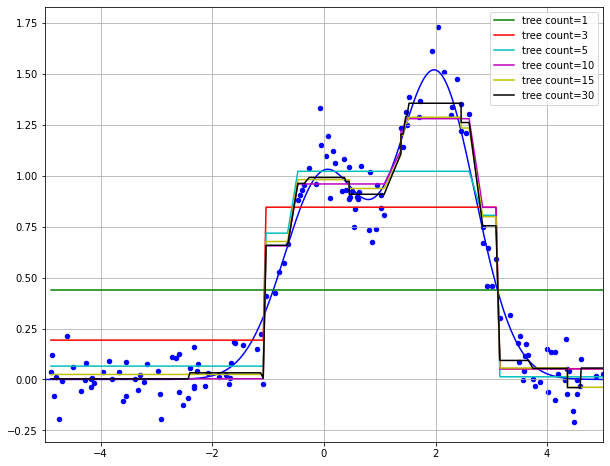

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 8))
fig.set(facecolor = 'white')
def predict_and_plot(model, X_test, y_test, title):
    y_predict = model.predict(X_test)

    plt.plot(X_test, f(X_test), "b")
    plt.scatter(X_train, y_train, c="b", s=20)
    plt.plot(X_test, y_predict, "g", lw=2)
    plt.xlim([-5, 5])
    plt.title("{} Loss: {:2f}".format(title, model.score(X_test, y_test)))
    plt.grid()
    



model = MyGradBoost(n_estimators=30, 
                    max_depth=1).fit(X_train, y_train)

ind =  [1,3,5,10,15,30]

# GradientBoostingRegressor
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
n_est = [1,3,5,10,15,30]
f = np.array(model.f_list)
for i, n in enumerate(n_est):
    colors = ['g', 'r', 'c', 'm', 'y', 'k']
    plt.plot(X_train, f[n-1], color=colors[i], label="tree count={}".format(n))

plt.xlim([-5, 5])   
plt.legend()
plt.grid()
plt.show()